In [1]:
import os
import sys
import pdb
import math
import random
import argparse
import numpy as np
import matplotlib
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from common_performance_stats import collect_txt_files, filter_txt_files, parse_data, ade_fde
from driving_performance_safety import find_collision_rate, find_near_miss_rate, find_ttc, \
    check_near_miss, get_corners, check_collision, check_collision_by_considering_headings, better_is_near_miss
from driving_performance_comfort import find_acceleration_and_jerk
from driving_performance_efficiency import efficiency_time_traveled, average_speed, path_tracking_error, distance_traveled
import pandas as pd
from temporal_consistency_calculation import calculate_consistency

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
file_path = '/home/phong/driving_data/official/gamma_planner/ca_new/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-56_r-6036439.txt'


In [4]:
action_list, ego_list, ego_path_list, exos_list, coll_bool_list, \
        pred_car_list, pred_exo_list, trial_list, depth_list, expanded_nodes, total_nodes, gamma_time = parse_data(file_path)


{'pos': [217.55882, 170.22578], 'heading': 1.79945, 'speed': 3.05101, 'vel': (-0.6915615877929162, 2.971599668594231), 'bb': (1.97403, 3.80221)}
{'id': 104, 'pos': [211.437, 172.842], 'heading': 0.557, 'vel': [0.641, 0.749], 'bb': (3.216, 5.8)}
Collision False | True | False | False
[[218.95106212 218.0892287  216.16657788 217.0284113  218.95106212]
 [168.5978793  172.30112706 171.8536807  168.15043294 168.5978793 ]]
[[218.95106212 168.5978793 ]
 [218.0892287  172.30112706]
 [216.16657788 171.8536807 ]
 [217.0284113  168.15043294]
 [218.95106212 168.5978793 ]]
[[209.82540633 214.74870649 213.04859367 208.12529351 209.82540633]
 [169.94399554 173.01011941 175.74000446 172.67388059 169.94399554]]
[[209.82540633 169.94399554]
 [214.74870649 173.01011941]
 [213.04859367 175.74000446]
 [208.12529351 172.67388059]
 [209.82540633 169.94399554]]


/tmp/ipykernel_915258/3928510162.py:20: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(outline_translated.T, True, color=color)


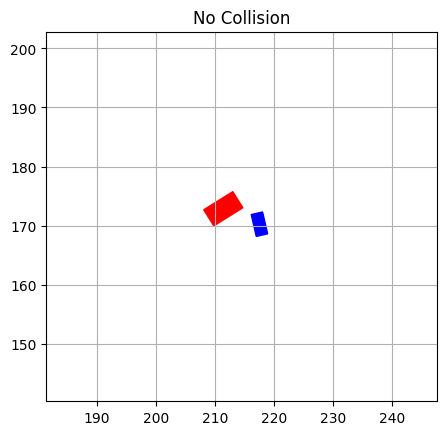

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def plot_vehicle1(ax, x, y, yaw, width, length, color='b'):
    outline = np.array([[-length / 2, -width / 2],
                        [length / 2, -width / 2],
                        [length / 2, width / 2],
                        [-length / 2, width / 2],
                        [-length / 2, -width / 2]]).T

    rot_matrix = np.array([[np.cos(yaw), -np.sin(yaw)],
                           [np.sin(yaw), np.cos(yaw)]])
    outline_rotated = np.dot(rot_matrix, outline)
    outline_translated = outline_rotated + np.array([[x], [y]])
    print(outline_translated)
    print(outline_translated.T)

    polygon = Polygon(outline_translated.T, True, color=color)
    ax.add_patch(polygon)


# Define the ego agent and exo agent parameters

ego_at_collision = ego_list[41]
all_exo_id_at_t = [o['id'] for o in exos_list[41]]
exo_at_collision = exos_list[41][all_exo_id_at_t.index(104)] # 41 is timestep, 104 is agent id
ego_x, ego_y, ego_yaw, ego_width, ego_length = ego_at_collision['pos'][0], ego_at_collision['pos'][1], \
                            ego_at_collision['heading'], ego_at_collision['bb'][0], ego_at_collision['bb'][1]
exo_x, exo_y, exo_yaw, exo_width, exo_length = exo_at_collision['pos'][0], exo_at_collision['pos'][1], \
            exo_at_collision['heading'], exo_at_collision['bb'][0], exo_at_collision['bb'][1]

print(ego_at_collision)
print(exo_at_collision)
# Check for collision
collision1 = check_near_miss(ego_at_collision, exo_at_collision, 0.5)
collision2 = check_collision(ego_at_collision, exo_at_collision)
collision3 = check_collision_by_considering_headings(ego_at_collision, exo_at_collision)
collision4 = better_is_near_miss(ego_at_collision, exo_at_collision)
print(f"Collision {collision1} | {collision2} | {collision3} | {collision4}")


# Plot the agents
fig, ax = plt.subplots()
plot_vehicle1(ax, ego_x, ego_y, ego_yaw, ego_width, ego_length, 'b')
plot_vehicle1(ax, exo_x, exo_y, exo_yaw, exo_width, exo_length, 'r')

ax.set_xlim(min(exo_x, ego_x)-30, max(exo_x, ego_x)+30)
ax.set_ylim(min(exo_y, ego_y)-30, max(exo_y, ego_y)+30)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Collision' if collision1 else 'No Collision')
plt.grid(True)
plt.show()


{'pos': [217.55882, 170.22578], 'heading': 1.79945, 'speed': 3.05101, 'vel': (-0.6915615877929162, 2.971599668594231), 'bb': (1.97403, 3.80221)}
{'id': 104, 'pos': [211.437, 172.842], 'heading': 0.557, 'vel': [0.641, 0.749], 'bb': (3.216, 5.8)}
Simple collision: True, complicated collision: False
 heading 1.79945
[[215.93091929584386, 168.83353787714276], [215.48347293508107, 170.7561887022122], [219.18672070415613, 171.6180221228572], [219.63416706491893, 169.69537129778777]]
 heading 0.557
[[208.53899554026196, 174.45359366818641], [211.26888059256459, 176.1537064883295], [214.33500445973806, 171.2304063318136], [211.60511940743544, 169.53029351167052]]


/tmp/ipykernel_915258/3785316431.py:34: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(np.array(ego_corners), True, color=color)


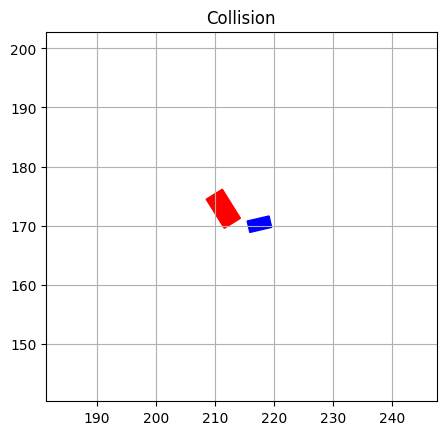

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def plot_vehicle(ax, agent, color='b'):

    width, length = agent['bb']
    x, y = agent['pos']
    heading = agent['heading']

    dx = width / 2
    dy = length / 2

    corners = [[x - dx, y + dy],
        [x + dx, y + dy],
        [x + dx, y - dy],
        [x - dx, y - dy],
    ]

    print(f' heading {heading}')

    # Rotate corners based on heading
    rotated_corners = []
    for corner in corners:
        x_diff = corner[0] - x
        y_diff = corner[1] - y
        new_x = x + (x_diff * np.cos(heading) - y_diff * np.sin(heading))
        new_y = y + (x_diff * np.sin(heading) + y_diff * np.cos(heading))
        rotated_corners.append([new_x, new_y])

    print(rotated_corners)
    ego_corners = rotated_corners
    polygon = Polygon(np.array(ego_corners), True, color=color)
    ax.add_patch(polygon)

# Define the ego agent and exo agent parameters

ego_at_collision = ego_list[41]
all_exo_id_at_t = [o['id'] for o in exos_list[41]]
exo_at_collision = exos_list[41][all_exo_id_at_t.index(104)] # 41 is timestep, 104 is agent id
ego_x, ego_y, ego_yaw, ego_width, ego_length = ego_at_collision['pos'][0], ego_at_collision['pos'][1], \
                            ego_at_collision['heading'], ego_at_collision['bb'][0], ego_at_collision['bb'][1]
exo_x, exo_y, exo_yaw, exo_width, exo_length = exo_at_collision['pos'][0], exo_at_collision['pos'][1], \
            exo_at_collision['heading'], exo_at_collision['bb'][0], exo_at_collision['bb'][1]

print(ego_at_collision)
print(exo_at_collision)
# Check for collision
collision = check_collision(ego_at_collision, exo_at_collision)
collision_by_considering_headings = check_collision_by_considering_headings(ego_at_collision, exo_at_collision)
print(f"Simple collision: {collision}, complicated collision: {collision_by_considering_headings}")
# Plot the agents
fig, ax = plt.subplots()
plot_vehicle(ax, ego_at_collision, 'b')
plot_vehicle(ax, exo_at_collision, 'r')

ax.set_xlim(min(exo_x, ego_x)-30, max(exo_x, ego_x)+30)
ax.set_ylim(min(exo_y, ego_y)-30, max(exo_y, ego_y)+30)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Collision' if collision else 'No Collision')
plt.grid(True)
plt.show()
